In [6]:
!pip install scikit-learn
!pip install xgboost
!pip install shap
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [1]:
# Standard data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Explainable AI
import shap

# Plotting settings
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
# Helper function to create a sample regression dataset
def create_synthetic_data(n_samples=1000, noise=0.1, random_state=42):
    """
    Creates a synthetic dataset for demonstrating XAI concepts.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    noise : float
        Amount of noise in the target variable
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target variable
    """
    np.random.seed(random_state)

    # Generate features
    X = pd.DataFrame({
        'feature1': np.random.normal(0, 1, n_samples),
        'feature2': np.random.normal(0, 1, n_samples),
        'feature3': np.random.normal(0, 1, n_samples)
    })

    # Generate target with non-linear relationships
    y = (X['feature1']**2 +
         np.exp(X['feature2']) +
         X['feature3'] +
         noise * np.random.normal(0, 1, n_samples))

    return X, y

In [3]:
# Helper function to evaluate and print model metrics
def print_model_metrics(y_true, y_pred, model_name="Model"):
    """
    Prints common regression metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 50)

I'll create the introduction section for the notebook that introduces XAI concepts in a clear, practical way.



```python
# Standard data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Explainable AI
import shap

# Plotting settings
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Helper function to create a sample regression dataset
def create_synthetic_data(n_samples=1000, noise=0.1, random_state=42):
    """
    Creates a synthetic dataset for demonstrating XAI concepts.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    noise : float
        Amount of noise in the target variable
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target variable
    """
    np.random.seed(random_state)
    
    # Generate features
    X = pd.DataFrame({
        'feature1': np.random.normal(0, 1, n_samples),
        'feature2': np.random.normal(0, 1, n_samples),
        'feature3': np.random.normal(0, 1, n_samples)
    })
    
    # Generate target with non-linear relationships
    y = (X['feature1']**2 +
         np.exp(X['feature2']) +
         X['feature3'] +
         noise * np.random.normal(0, 1, n_samples))
    
    return X, y

# Helper function to evaluate and print model metrics
def print_model_metrics(y_true, y_pred, model_name="Model"):
    """
    Prints common regression metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 50)

```

Let's start with the markdown introduction in the notebook:

# Understanding AI Models: Making the Black Box Transparent

## 1. Introduction to Explainable AI (XAI)

### What is Explainable AI?
Explainable AI (XAI) refers to methods and techniques that help us understand and interpret predictions made by machine learning models. Instead of treating our models as black boxes, XAI allows us to:
- Understand why a model made a specific prediction
- Identify which features are most important
- Detect potential biases
- Build trust in model predictions

### Why is Model Interpretability Important?
Consider these real-world scenarios:
1. **Medical Diagnosis**: When a model predicts a patient's condition, doctors need to understand which factors led to that prediction
2. **Credit Approval**: Banks must explain why a loan application was rejected
3. **Autonomous Vehicles**: Engineers need to understand why a self-driving car made certain decisions

### Key Concepts
Before diving into practical examples, let's understand some fundamental concepts:

1. **Local vs. Global Explanations**
   - Local: Explains individual predictions
   - Global: Explains overall model behavior

2. **Feature Importance**
   - Which inputs most influence the model's decisions?
   - How do different features interact?

3. **SHAP (SHapley Additive exPlanations)**
   - Based on game theory
   - Provides consistent and locally accurate explanations
   - Combines local and global interpretability



In [4]:
# Create synthetic dataset
X, y = create_synthetic_data(n_samples=1000)

# Display first few rows
print("Sample of our synthetic dataset:")
print("\nFeatures:")
print(X.head())
print("\nTarget:")
print(y.head())

Sample of our synthetic dataset:

Features:
   feature1  feature2  feature3
0  0.496714  1.399355 -0.675178
1 -0.138264  0.924634 -0.144519
2  0.647689  0.059630 -0.792420
3  1.523030 -0.646937 -0.307962
4 -0.234153  0.698223 -1.893615

Target:
0    3.433353
1    2.309504
2    0.647164
3    2.724075
4    0.227047
dtype: float64


In [25]:
def plot_feature_importance(model, X, feature_names=None):
    """
    Plots feature importance for any sklearn model that supports feature_importances_

    Parameters:
    -----------
    model : sklearn estimator
        Fitted model with feature_importances_ attribute
    X : pd.DataFrame
        Feature matrix
    feature_names : list, optional
        List of feature names
    """
    if feature_names is None:
        feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]

    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


In [6]:
def compare_local_global(model, X, y, sample_idx=0):
    """
    Demonstrates difference between local and global interpretation

    Parameters:
    -----------
    model : fitted model
        Model with predict method
    X : pd.DataFrame
        Feature matrix
    y : array-like
        Target values
    sample_idx : int
        Index of sample to explain locally
    """
    # Global importance using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(15, 5))

    # Plot 1: Global importance
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title("Global Feature Importance")

    # Plot 2: Local explanation
    plt.subplot(1, 2, 2)
    local_shap = explainer.shap_values(X.iloc[sample_idx:sample_idx+1])[0]
    feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
    local_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(local_shap)
    }).sort_values('importance', ascending=True)

    sns.barplot(data=local_importance, x='importance', y='feature')
    plt.title(f"Local Explanation for Instance {sample_idx}")

    plt.tight_layout()
    plt.show()

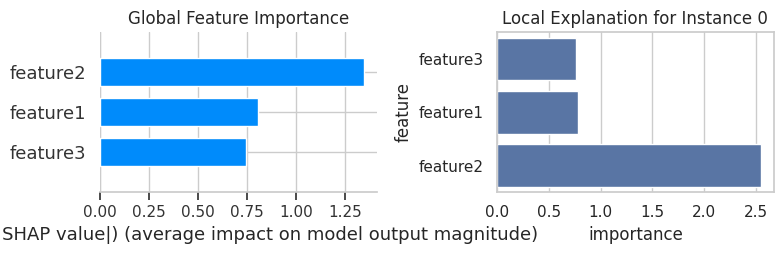

In [7]:
# Create and fit a model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Compare local and global interpretations
compare_local_global(model, X, y)

## Understanding SHAP Values: Global vs Local Interpretation

Let's break down this code step by step to understand how SHAP helps us interpret our model:

### 1. Setting up SHAP Explainer
```python
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
```
- `TreeExplainer`: Special SHAP explainer for tree-based models (like Random Forests)
- `shap_values`: Calculates how each feature contributes to each prediction

### 2. Creating Global Importance Plot
```python
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("Global Feature Importance")
```
This shows:
- Overall impact of each feature across ALL predictions
- Longer bars = More important features
- Direction (positive/negative) of feature impact

### 3. Creating Local Explanation Plot
```python
local_shap = explainer.shap_values(X.iloc[sample_idx:sample_idx+1])[0]
```
- Takes ONE specific instance from our dataset
- Shows how each feature contributed to THIS SPECIFIC prediction

### 4. Processing Local Results
```python
local_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(local_shap)
}).sort_values('importance', ascending=True)
```
- Creates a DataFrame with feature names and their importance
- Takes absolute values to show magnitude of impact
- Sorts features by their importance

### Why This Matters
- **Global View**: Helps understand overall model behavior
- **Local View**: Explains individual predictions
- Together, they provide both the big picture and detailed insights

For example, a feature might be globally important but have little impact on a specific prediction, or vice versa. This dual perspective is crucial for thorough model interpretation.

## Understanding SHAP Explainers in Machine Learning

### What is a SHAP Explainer?
A SHAP Explainer is a tool that calculates SHAP (SHapley Additive exPlanations) values to interpret model predictions. Think of it as a translator between your complex model and human-understandable explanations.

### Types of SHAP Explainers

1. **TreeExplainer**
```python
explainer = shap.TreeExplainer(model)
```
- **When to use**: For tree-based models (Random Forest, XGBoost, LightGBM)
- **Advantages**: Fast, exact SHAP values
- **Examples**:
  - Random Forest Regressor/Classifier
  - Decision Trees
  - Gradient Boosting Models

2. **KernelExplainer**
```python
explainer = shap.KernelExplainer(model.predict, X_train)
```
- **When to use**: For ANY model (model-agnostic)
- **Advantages**: Works with any model
- **Disadvantages**: Slower, approximates values
- **Examples**:
  - Neural Networks
  - SVM
  - Custom models

3. **DeepExplainer**
```python
explainer = shap.DeepExplainer(model, X_train)
```
- **When to use**: Specifically for deep learning models
- **Advantages**: Optimized for neural networks
- **Examples**:
  - TensorFlow models
  - PyTorch models

4. **LinearExplainer**
```python
explainer = shap.LinearExplainer(model, X_train)
```
- **When to use**: For linear models
- **Advantages**: Fast, exact for linear models
- **Examples**:
  - Linear Regression
  - Logistic Regression

### Choosing the Right Explainer

```python
def choose_shap_explainer(model_type, model, X_train):
    """
    Helper function to choose appropriate SHAP explainer
    """
    if hasattr(model, 'tree_'):  # Tree-based models
        return shap.TreeExplainer(model)
    elif 'linear' in model_type.lower():  # Linear models
        return shap.LinearExplainer(model, X_train)
    elif 'keras' in str(type(model)):  # Deep learning
        return shap.DeepExplainer(model, X_train)
    else:  # Default to KernelExplainer
        return shap.KernelExplainer(model.predict, X_train)
```

### Common Usage Pattern

```python
# 1. Create explainer
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values
shap_values = explainer.shap_values(X)

# 3. Visualize results
# Global interpretation
shap.summary_plot(shap_values, X)

# Local interpretation for one instance
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0])
```

### Best Practices
1. Always use the most specific explainer for your model type
2. For large datasets, consider using a subset for KernelExplainer
3. Be aware of computational resources needed for different explainers
4. Consider the trade-off between speed and accuracy

### Warning Signs
- Long computation times → Consider using a different explainer or sampling data
- Memory errors → Reduce dataset size or use batch processing
- Inconsistent results → Check if using appropriate explainer for your model


In [7]:
# Required imports
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def prepare_data():
    """
    Prepares California housing dataset for demonstration
    Returns: X_train, X_test, y_train, y_test, model
    """
    # Load and prepare data
    housing = fetch_california_housing()
    X = pd.DataFrame(housing.data, columns=housing.feature_names)
    y = housing.target

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train a simple model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    return X_train, X_test, y_train, y_test, model

In [9]:
def basic_shap_explanation(model, X):
    """
    Shows basic SHAP values and their interpretation
    """
    # Create explainer
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for first instance
    shap_values = explainer.shap_values(X.iloc[0:1])

    # Get base value (average model output)
    base_value = explainer.expected_value

    # Create DataFrame with feature contributions
    contribution_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_value': shap_values[0],
        'Feature_value': X.iloc[0].values
    })

    # Sort by absolute SHAP value
    contribution_df['abs_shap'] = abs(contribution_df['SHAP_value'])
    contribution_df = contribution_df.sort_values('abs_shap', ascending=False)

    print("Base value (average prediction):", base_value)
    print("\nFeature contributions for first instance:")
    print(contribution_df)
    print("\nActual prediction:", base_value + sum(shap_values[0]))

    return explainer, shap_values

In [14]:
def visualize_shap_explanations(model, X, explainer):
    """
    Creates various SHAP visualization plots with improved layout
    """
    # Create figure with more height and proper spacing
    plt.figure(figsize=(20, 16))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 1. Global Feature Importance
    plt.subplot(2, 2, 1)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    ax1 = plt.gca()
    ax1.set_title("Global Feature Importance", pad=20, fontsize=14)

    # 2. SHAP Values for Single Prediction
    plt.subplot(2, 2, 2)
    plt.clf()  # Clear current subplot
    plt.subplot(2, 2, 2)
    shap.force_plot(
        explainer.expected_value,
        explainer.shap_values(X.iloc[0:1])[0],
        X.iloc[0:1],
        show=False,
        matplotlib=True
    )
    ax2 = plt.gca()
    ax2.set_title("Force Plot for Single Prediction", pad=20, fontsize=14)

    # 3. Dependence Plot
    plt.subplot(2, 2, 3)
    shap.dependence_plot(
        0,  # First feature
        shap_values,
        X,
        show=False
    )
    ax3 = plt.gca()
    ax3.set_title("Dependence Plot (Feature Interactions)", pad=20, fontsize=14)

    # 4. Local Feature Importance
    plt.subplot(2, 2, 4)
    shap_local = pd.DataFrame(
        explainer.shap_values(X.iloc[0:1])[0],
        columns=['SHAP_value'],
        index=X.columns
    )
    shap_local['abs_shap'] = abs(shap_local['SHAP_value'])
    shap_local = shap_local.sort_values('abs_shap', ascending=True)

    # Create horizontal bar plot with better spacing
    bars = plt.barh(range(len(shap_local)), shap_local['SHAP_value'])
    plt.yticks(range(len(shap_local)), shap_local.index)

    # Add value labels to the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f'{width:.3f}',
                ha='left' if width >= 0 else 'right',
                va='center',
                fontsize=10)

    ax4 = plt.gca()
    ax4.set_title("Local Feature Importance (Single Instance)", pad=20, fontsize=14)

    # Final layout adjustments
    plt.tight_layout()
    plt.show()

In [17]:
def visualize_force_plot(model, X):
    """
    Creates a clear force plot visualization for a single prediction
    """
    # Create the explainer
    explainer = shap.TreeExplainer(model)

    # Get SHAP values for first instance
    shap_values = explainer.shap_values(X.iloc[0:1])

    # Create figure with appropriate size
    plt.figure(figsize=(15, 4))

    # Create force plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        X.iloc[0:1],
        show=False,
        matplotlib=True,
        text_rotation=0,        # Ensure text is horizontal
        contribution_threshold=0.05  # Only show significant contributions
    )

    # Improve layout
    plt.tight_layout()
    plt.gcf().set_facecolor('white')  # White background
    plt.gca().set_position([0.1, 0.3, 0.8, 0.5])  # Adjust plot position

    # Add title with some spacing
    plt.title("SHAP Force Plot: Feature Contributions to Prediction",
              pad=20,
              fontsize=14)

    plt.show()


In [15]:
def demonstrate_different_explainers(X, y):
    """
    Shows how to use different SHAP explainers
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.svm import SVR

    # 1. Linear model with LinearExplainer
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    linear_explainer = shap.LinearExplainer(linear_model, X)

    # 2. SVM with KernelExplainer
    svm_model = SVR(kernel='rbf')
    svm_model.fit(X[:100], y[:100])  # Using subset for speed
    kernel_explainer = shap.KernelExplainer(svm_model.predict, X[:100])

    print("Available explainers demonstrated:")
    print("1. TreeExplainer: Best for tree-based models (shown above)")
    print("2. LinearExplainer: For linear models")
    print("3. KernelExplainer: Model-agnostic, works with any model")
    print("\nOther explainers:")
    print("4. DeepExplainer: For deep learning models")
    print("5. GradientExplainer: Also for deep learning")
    print("6. PermutationExplainer: Alternative model-agnostic approach")

<Figure size 1500x400 with 0 Axes>

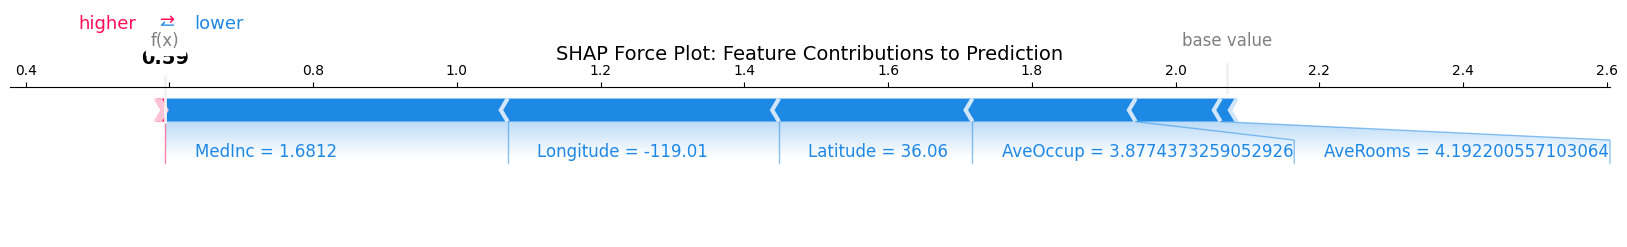

In [18]:
    X_train, X_test, y_train, y_test, model = prepare_data()
    visualize_force_plot(model, X_test)

<Figure size 1000x600 with 0 Axes>

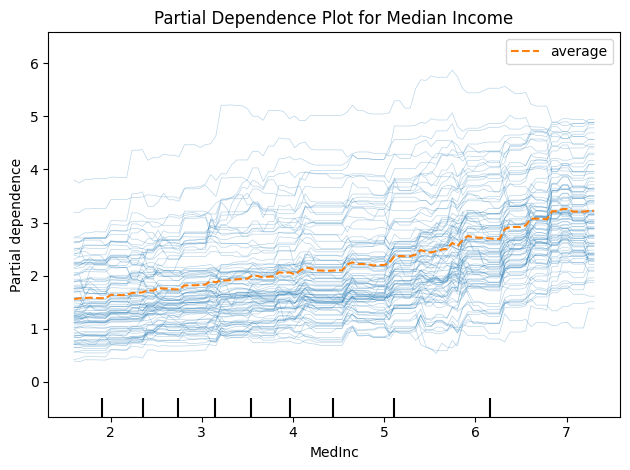

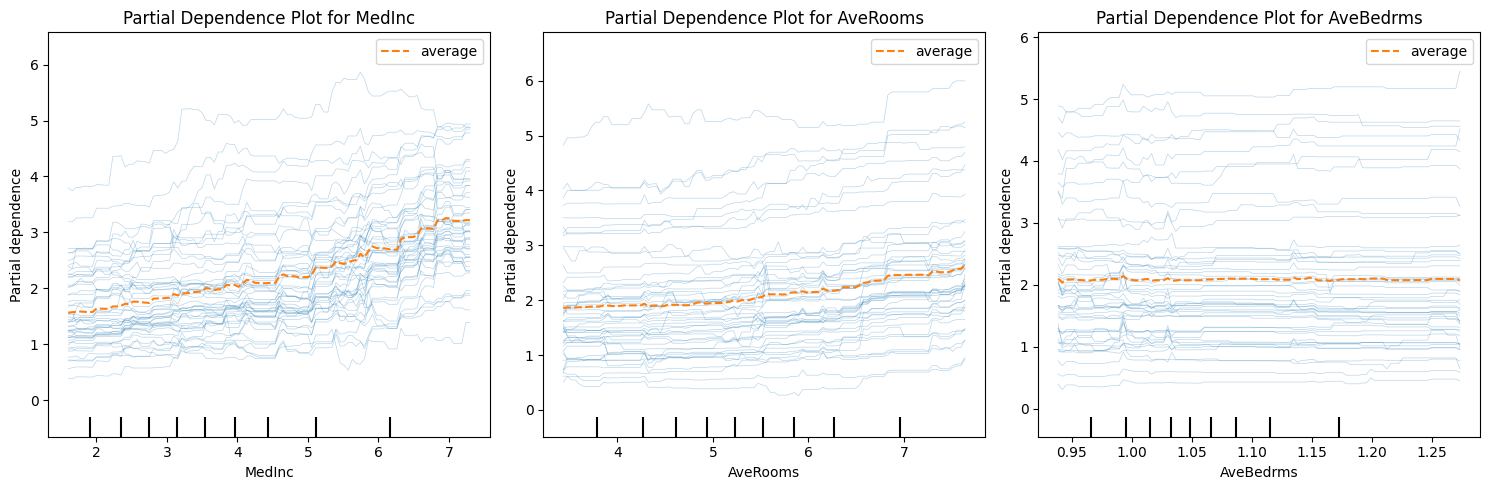

In [24]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import xgboost as xgb

# Prepare data
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Now for single feature PDP
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X,
    ['MedInc'],  # Changed to actual feature name from housing dataset
    kind='both',
    subsample=100,
    random_state=42
)
plt.title("Partial Dependence Plot for Median Income")
plt.tight_layout()
plt.show()

# For multiple features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['MedInc', 'AveRooms', 'AveBedrms']  # Changed to actual feature names
for ax, feature in zip(axes, features):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        [feature],
        ax=ax,
        kind='both',
        subsample=50,
        random_state=42
    )
    ax.set_title(f"Partial Dependence Plot for {feature}")
plt.tight_layout()
plt.show()

## Partial Dependence Plots

Partial Dependence Plots (PDPs) are a useful tool for understanding the relationship between a model's features and its predictions. They show the marginal effect of a feature on the model's output, averaged over the values of the other features.

The code you provided demonstrates how to create partial dependence plots using the `PartialDependenceDisplay` class from the `sklearn.inspection` module.

### Single Feature PDP
The first part of the code creates a single partial dependence plot for the feature `feature1`:

```python
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model,  # The fitted model
    X,      # Feature matrix
    ['feature1'],  # Features to plot
    kind='both',   # Show both PDP and ICE
    subsample=100, # Number of ICE curves to plot
    random_state=42 # For reproducibility
)
plt.title("Partial Dependence Plot for feature1")
plt.tight_layout()
plt.show()
```

This will create a 3x1 grid of partial dependence plots, one for each of the features feature1, feature2, and feature3. Each plot will show the PDP and ICE curves for the corresponding feature.
The PartialDependenceDisplay.from_estimator() function takes in the following parameters:

model: The fitted machine learning model.
X: The feature matrix.
features: The feature(s) to plot.
ax (optional): The matplotlib axis to use for the plot.
kind (optional): Specifies whether to show the PDP, ICE, or both.
subsample (optional): The number of ICE curves to plot (to avoid overcrowding).
random_state (optional): The random state for reproducibility.

The output of these plots can help you understand how changes in the feature values affect the model's predictions, which can be useful for model interpretation and debugging.

A Partial Dependence Plot (PDP) is a visualization technique used to help interpret the output of machine learning models. It shows the marginal effect that a feature has on the model's predictions, averaged over the values of the other features.
The key idea behind a PDP is to isolate the effect of one feature on the model's predictions, while accounting for the average effects of the other features. This allows you to understand how changes in a specific feature value impact the model's output, which can be very helpful for understanding the model's behavior and identifying important features.
To create a PDP, the process involves:

Fixing the values of all features except the feature of interest.
Calculating the average model output across all the fixed feature values.
Plotting the average model output against the values of the feature of interest.

This results in a curve or line that represents the average change in the model's output as the feature of interest is varied. Peaks and valleys in the PDP indicate ranges of the feature where the model is making higher or lower predictions, respectively.
PDPs are useful because they provide a simple and intuitive way to understand the relationship between individual features and the model's predictions. They can help identify nonlinear relationships, interaction effects, and other patterns that may not be immediately obvious from the model's coefficients or other summary statistics.

In [20]:
# Import necessary libraries
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

In [21]:
# Load and preprocess the Diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate feature importance using the model's coefficients
feature_importances = abs(model.coef_)
feature_names = diabetes.feature_names

<Figure size 1000x600 with 0 Axes>

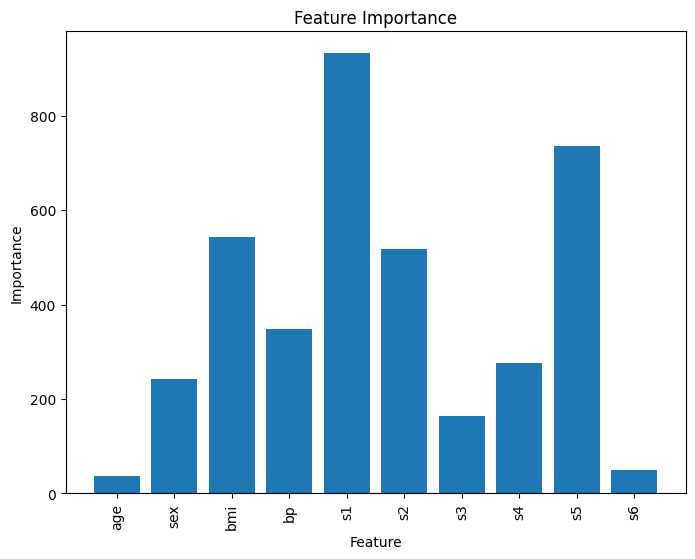

In [23]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()